# Prepare for machine learning
This notebook shows how to prepare a dataset of model runs for machine learning. The dataset consists of a set of flood scenarios. 
The steps to make the dataset suitable for machine learning consist of the following:

- Read: Open the dataset
- Create extra variables
- Explore: Check ranges of data and check for missing values
- Tensors: Define a list of available input and output variables, including data types and shapes
- Sample: Define a sampling strategy to go from data to trainable examples

In [1]:
import os
import pathlib
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches 
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import tensorflow as tf
import tqdm
import xarray as xr
from rasterio.warp import Resampling, calculate_default_transform, reproject
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

# Suppress all warnings
warnings.filterwarnings("ignore")

# Open dataset
This dataset consists of a number of reconstructed flood events. For each event a number of environmental quantities are stored. In this step we will look at the available variables and the metadata of the variables. 
We will determine:
- when did the events occur
- where were they recorded
- what quantities are available


In [2]:
base_dir_name = "~/Library/CloudStorage/OneDrive-SharedLibraries-StichtingDeltares/Tiaravanni Hermawan - Indonesia case for students"
base_dir = pathlib.Path(base_dir_name).expanduser().resolve()
mf_path = base_dir / "semarang/hydromt_data_1/to_clean"


## Multi file dataset
The mf_path is a [path](https://docs.python.org/3/library/pathlib.html) to a directory. In that directory a number of files exist. Each file represents a recorded event. We will use the [open_mfdataset](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html) function to read all files at once. 

In [3]:
# let's list the paths relative to their parent
[path.relative_to(mf_path) for path in mf_path.glob('*.nc')]

[PosixPath('event_3.nc'),
 PosixPath('event_6.nc'),
 PosixPath('event_2.nc'),
 PosixPath('event_5.nc'),
 PosixPath('event_1.nc'),
 PosixPath('event_4.nc')]

In [4]:
# Let's read all the paths in order
paths = list(sorted(mf_path.glob("*.nc")))
# this will create a dataset that we refer to as ds
ds = xr.open_mfdataset(paths, combine="nested", concat_dim='events')
# we can create an interactive table that shows all the variables by printing the dataset
ds

<xarray.Dataset>
Dimensions:               (events: 6, y: 1923, x: 1920)
Coordinates:
  * events                (events) int32 1 2 3 4 5 6
  * y                     (y) float64 -7.547e+05 -7.547e+05 ... -8.123e+05
  * x                     (x) float64 1.733e+06 1.733e+06 ... 1.791e+06
Data variables: (12/16)
    floodmaps             (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    floodmaps_gis         (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    basin                 (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    flood_prone_area      (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    permanent_water_p50   (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    cn_avg                (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    ...                    ...
    flowdir_cosine_y      (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    flowdir_degrees       (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    flowdir_sine_y        (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    manning_values        (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    slope                 (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    uparea_idw            (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>

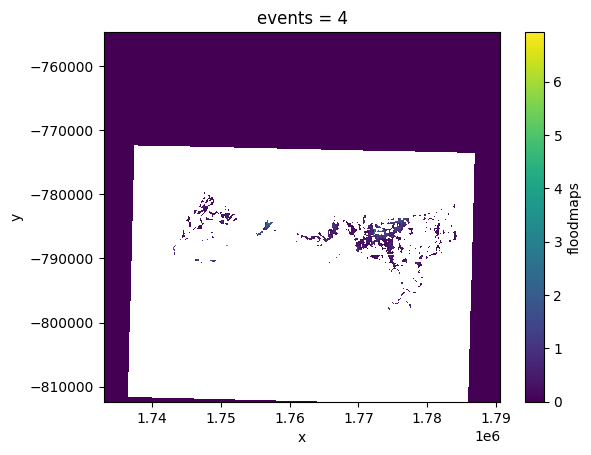

In [5]:
# We can select an event and a variable plot its values
ds.sel(events=4).floodmaps.plot()

# Extra variables
In this step we can reshape data and creat eextra variables. We need two extra variables. 
Here we compute an extra variable mask. This defines our area of interest (mask==0) and ignore unfloodable areas (mask==1). We base this on the flood depth compound. 
We'll also create an extra map of flooded area, based on our SFINCS computations. If it is flooded we can provide extra reward if you calculate this correctly in the right location.


In [6]:
ds["mask"] = ds["floodmaps_gis"].fillna(0) <= 0.001
ds["is_flooded"] = ds["floodmaps"] >= 0.5

# Explore: Check ranges of data and check for missing values

Here we go to the exploratory data analysis step. Here we visualize all the variables and determine the domain or range (min, max) of the variables and determine how they deal with missing values. Here we can see the following (this might change):
- floodmaps:  missing when not flooded, 0 outside of domain)
- floodmaps_gis: missing when not flooded
- basin, flood prone area, permanent water: dichotomous
- cn_(dry/wet/avg), uparea_idw: 0 outside of warped domain
- distance to rive and manningr: 0 outside of domain, missing outside catchment
- flowdir_degrees is already linearized into sin/cos



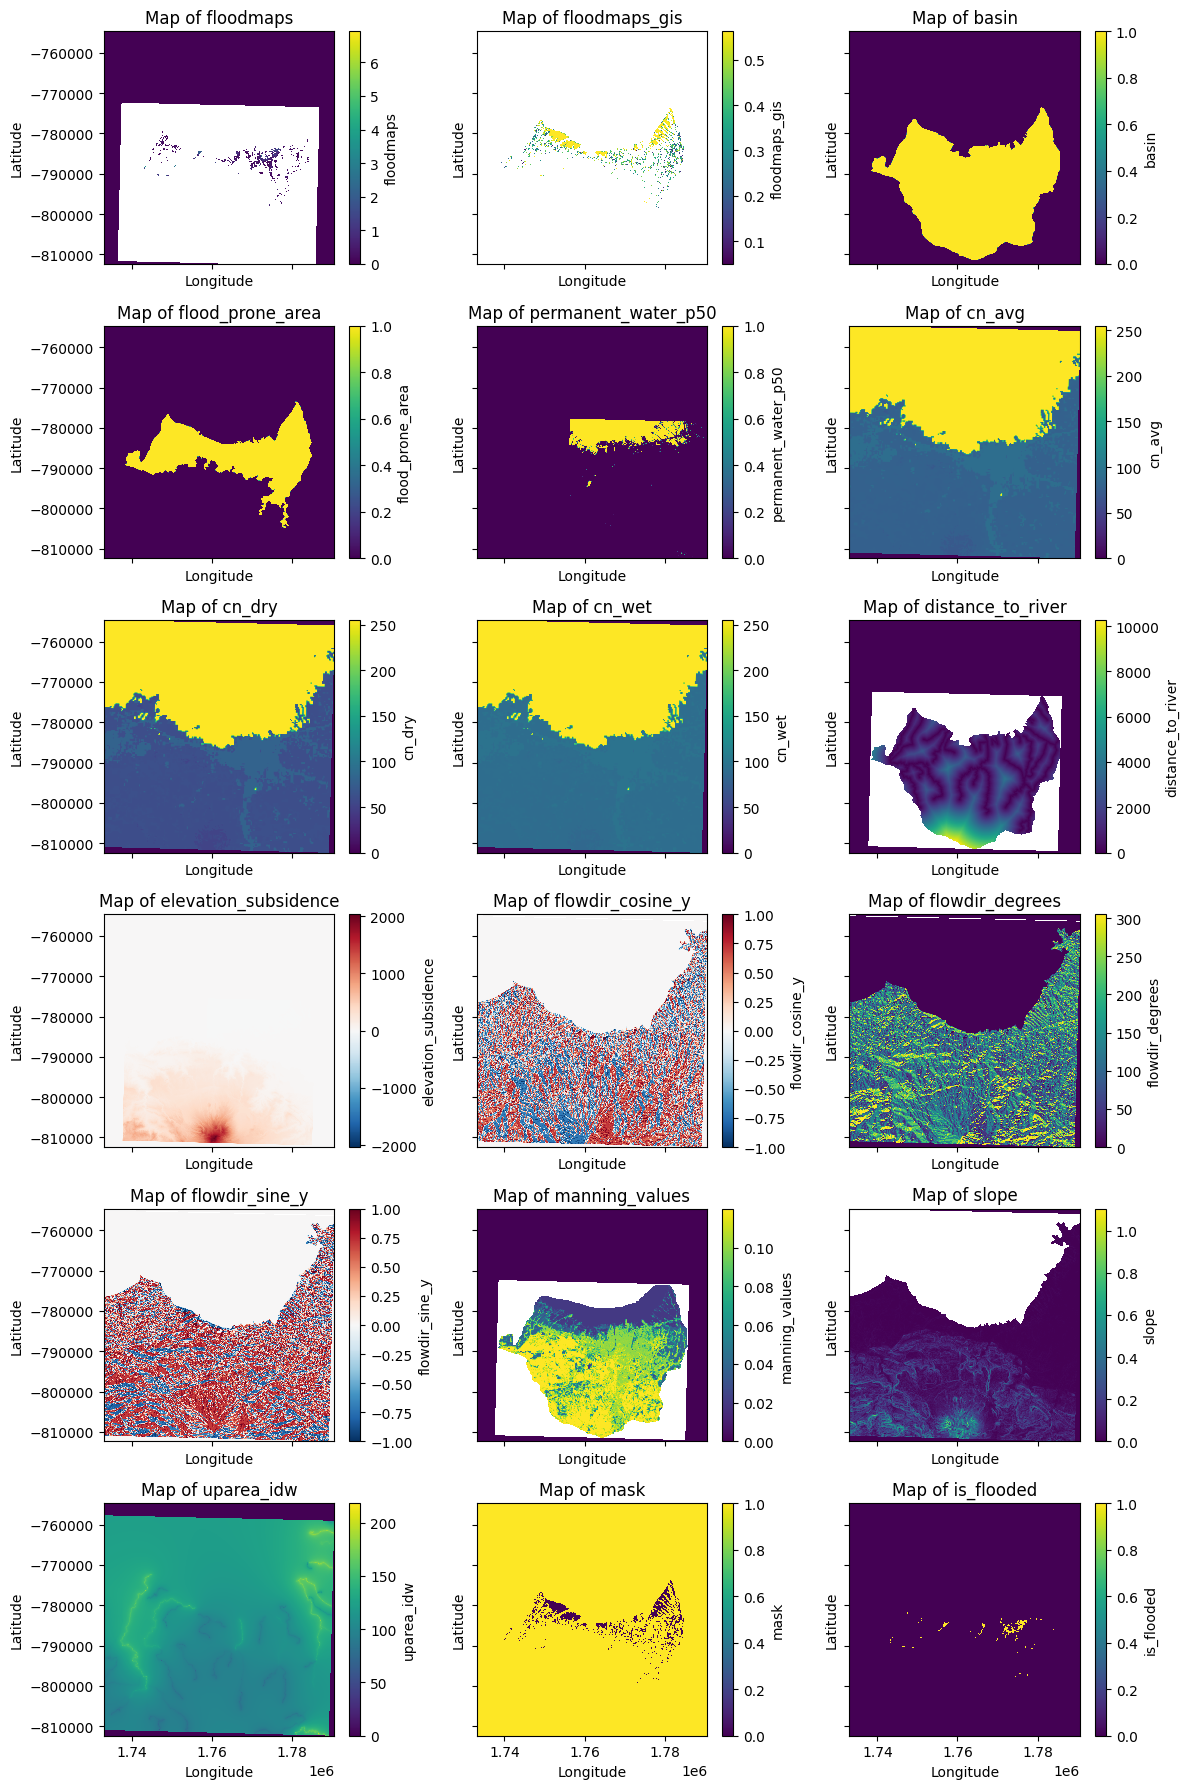

In [7]:
# Get a list of data variables (excluding dimensions and attributes)
data_variables = [
    var
    for var in ds.variables
    if (ds[var].dtype != "S" and len(ds[var].shape) >= 2)
]

# Calculate the number of rows needed for the grid (2 columns)
num_vars = len(data_variables)
num_rows = (
    num_vars + 1
) // 3  # Add 1 to round up if there's an odd number of variables

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows), sharex=True, sharey=True)

# Loop through each variable and create a map in a subplot
for ax, variable_name in zip(axes.flat, data_variables):
    variable = ds[variable_name][0]
    variable.plot(ax=ax)

    ax.set_title(f"Map of {variable_name}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Tensors
Here we will extract all variables in a format that we can use in our neural network. We will refer to these as tensors


In [8]:
img_shape = (128, 128)
# let's define our inputs
tensors = [
    {
        "name": "soil_moisture",
        "var": "cn_avg",
        "shape": img_shape,
        "dtype": "float32",
        "dims": ["x", "y"],
        "role": "input",
        "min": 0,
        "max": 1
    },
    {
        "name": "flood_hand",
        "var": "floodmaps_gis",
        "shape": img_shape,
        "dtype": "float32",
        "dims": ["x", "y"],
        "role": "input",
        "min": 0,
        "max": 1
    },
    # static maps
    {
        "name": "elevation",
        # with subsidence included
        "var": "elevation_subsidence",
        "shape": img_shape,
        "dtype": "float32",
        "dims": ["x", "y"],
        "role": "input",
        "min": 0,
        "max": 100
    },
    {
        "name": "is_permanent_water",
        "var": "permanent_water_p50",
        "shape": img_shape,
        "dtype": "bool",
        "dims": ["x", "y"],
        "role": "input",
        "min": 0,
        "max": 1
    },
    {
        "name": "mask",
        "var": "mask",
        "shape": img_shape,
        "dtype": "bool",
        "dims": ["x", "y"],
        "role": "input",
        "min": 0,
        "max": 1
    },
    {
        "name": "is_flooded",
        "var": "is_flooded",
        "shape": img_shape,
        "dtype": "float32",
        "dims": ["x", "y"],
        "role": "output",
        "min": 0,
        "max": 1,
    },
    {
        "name": "flood_depth",
        "var": "floodmaps",
        "shape": img_shape,
        "dtype": "float32",
        "dims": ["x", "y"],
        "role": "output",
        "min": 0,
        "max": 3,
    },
    {
        "name": "M_slices",
        "var": "M_slices",
        "shape": img_shape,
        "dtype": "int64",
        "dims": ["x", "y"],
        "role": "context",
        "min": 0,
        "max": 1024 * 1024 * 1024,
    },
    {
        "name": "N_slices",
        "var": "N_slices",
        "shape": img_shape,
        "dtype": "int64",
        "dims": ["x", "y"],
        "role": "context",
        "min": 0,
        "max": 1024 * 1024 * 1024,
    },
    {
        "name": "M_start_stop",
        "var": "M_start_stop",
        "shape": img_shape,
        "dtype": "int64",
        "dims": ["minmax"],
        "role": "context",
        "min": 0,
        "max": 1024 * 1024 * 1024,
    },
    {
        "name": "N_start_stop",
        "var": "N_start_stop",
        "shape": img_shape,
        "dtype": "int64",
        "dims": ["minmax"],
        "role": "context",
        "min": 0,
        "max": 1024 * 1024 * 1024,
    },
    
]

df = pd.DataFrame(tensors)
df.to_json('./tensors.json', orient='records')
df

,name,var,shape,dtype,dims,role,min,max
0,soil_moisture,cn_avg,"(128, 128)",float32,"[x, y]",input,0,1
1,flood_hand,floodmaps_gis,"(128, 128)",float32,"[x, y]",input,0,1
2,elevation,elevation_subsidence,"(128, 128)",float32,"[x, y]",input,0,100
3,is_permanent_water,permanent_water_p50,"(128, 128)",bool,"[x, y]",input,0,1
4,mask,mask,"(128, 128)",bool,"[x, y]",input,0,1
5,is_flooded,is_flooded,"(128, 128)",float32,"[x, y]",output,0,1
6,flood_depth,floodmaps,"(128, 128)",float32,"[x, y]",output,0,3
7,M_slices,M_slices,"(128, 128)",int64,"[x, y]",context,0,1073741824
8,N_slices,N_slices,"(128, 128)",int64,"[x, y]",context,0,1073741824
9,M_start_stop,M_start_stop,"(128, 128)",int64,[minmax],context,0,1073741824


In [9]:
def add_tensor_spec(spec):
    for row in spec:
        tensor_spec = tf.TensorSpec(
            shape=row["shape"], dtype=row["dtype"], name=row["name"]
        )
        row["tensor_spec"] = tensor_spec
    return spec


specs = add_tensor_spec(tensors)
specs

# select non-context variables
var_names = list(df.query("role != 'context'")['var'].values)
var_names

['cn_avg',
 'floodmaps_gis',
 'elevation_subsidence',
 'permanent_water_p50',
 'mask',
 'is_flooded',
 'floodmaps']

In [10]:
# we can now use our tensor list to extract only the variables that we are interested in.
arr = ds[var_names]
arr

<xarray.Dataset>
Dimensions:               (events: 6, y: 1923, x: 1920)
Coordinates:
  * events                (events) int32 1 2 3 4 5 6
  * y                     (y) float64 -7.547e+05 -7.547e+05 ... -8.123e+05
  * x                     (x) float64 1.733e+06 1.733e+06 ... 1.791e+06
Data variables:
    cn_avg                (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    floodmaps_gis         (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    elevation_subsidence  (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    permanent_water_p50   (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    mask                  (events, y, x) bool dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    is_flooded            (events, y, x) bool dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>
    floodmaps             (events, y, x) float32 dask.array<chunksize=(1, 1923, 1920), meta=np.ndarray>

# Sampling
Now we will define our sampling strategy. Our goal here is to take the dataset and to take a subset of the data and present it to the neural network as an [example](https://www.tensorflow.org/api_docs/python/tf/train/Example). Examples are the individual data points or instances, features are the characteristics or attributes of these examples, and tensors are the data structures used to represent and process these features within deep neural networks

Neural Networks work best if they are fed with images of consistent sizes. Preferably they are sized in the order of powers of 2. That allows the [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit)'s that are used to train the models to make optimal use of their memory.  So we try to store our information in tensors of such shapes

We also make use of this to extract more examples of our data than that we have data. 

In [11]:
def compute_slices(shape, sample_shape):
    """take an array shape and compute the possible windows which to sample from
    returns a dictionary with the following information:
    - M_slices, N_slices -> mgrid of the coordinates of a list of all the windows
    - M/N_start_stop -> ranges of windows in the coordinates of the  original array
    
    """
    # subdivide in 25% steps
    window_m_interval = sample_shape[0] // 4
    window_n_interval = sample_shape[1] // 4
    window_slice = np.s_[::window_m_interval, ::window_n_interval]
    n_rows, n_columns = shape
    
    # Create images of indices
    
    M, N = np.mgrid[:n_rows, :n_columns]
    M_windows = np.lib.stride_tricks.sliding_window_view(
        M, 
        sample_shape
    )
    N_windows = np.lib.stride_tricks.sliding_window_view(
        N, 
        sample_shape
    )
    # Take the same slcies
    M_slices = M_windows[window_slice].reshape(-1, *sample_shape)
    N_slices = N_windows[window_slice].reshape(-1, *sample_shape)
    
    # look up intervals
    M_start_stop = np.c_[M_slices[..., 0, 0], M_slices[..., -1, -1]]
    N_start_stop = np.c_[N_slices[..., 0, 0], N_slices[..., -1, -1]]

    result = {
        "M_slices": M_slices,
        "N_slices": N_slices, 
        "M_start_stop": M_start_stop,
        "N_start_stop": N_start_stop
    }
    return result



In [12]:
arr_shape = arr['floodmaps'].shape[1:]
img_shape = (128, 128)
slices = compute_slices(arr_shape, sample_shape=img_shape)


# We have 20x18 windows of size 128, 128, we'll reorganize that to 360 examples of 128x128
# M_start_stop.shape, N_start_stop.shape
slices["M_slices"].shape , slices["N_start_stop"][:5]

((3249, 128, 128),
 array([[  0, 127],
        [ 32, 159],
        [ 64, 191],
        [ 96, 223],
        [128, 255]]))

In [13]:
# let's take a random sample and plot it
idx = np.arange(slices["N_start_stop"].shape[0])
sample = np.random.choice(idx, 8)

sample_i = sample[0]
print(sample_i)

# row indices
M_i = slices["M_start_stop"][sample_i]
# columns
N_i = slices["N_start_stop"][sample_i]

ll, ul, ur, lr = [(0, 0), (0, -1), (-1, -1), (-1, 0)]
corners = np.array([ll, ul, ur, lr])

coords = np.c_[N_i[corners[:, 0]], M_i[corners[:, 1]]]

s = np.s_[M_i[0]:M_i[1], N_i[0]:N_i[1]]
selected = ds['floodmaps'][0][s]
selected.min().values

vmin, vmax = selected.min().values, selected.max().values

345


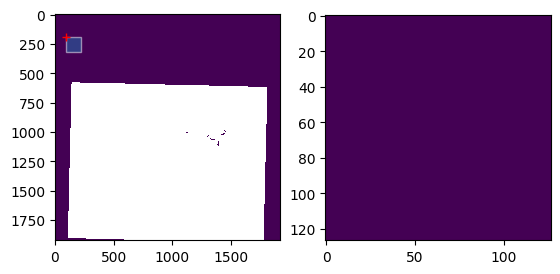

In [14]:
fig, axes = plt.subplots(ncols=2)
im = axes[0].imshow(ds['floodmaps'][0], vmin=vmin, vmax=vmax)
axes[0].plot(N_i[0], M_i[0], 'r+')
poly = matplotlib.patches.Polygon(coords, alpha=0.5, edgecolor='white')
axes[0].add_patch(poly)
axes[1].imshow(selected, vmin=vmin, vmax=vmax)

In [15]:
def array_to_examples(ds, specs, n_samples=8, n_flood_limit=9):
    # use a random number generator to permute the data

    # don't alter original
    specs = specs.copy()

    rng = np.random.default_rng()

    # compute the slices based on this variable
    slices = compute_slices(ds['floodmaps'].shape, sample_shape=img_shape)

    # take a quarter overlapping windows (each next window is 75% the same as the previous one)
    window_interval = img_shape[0] // 4
    window_slice = np.s_[::window_interval, ::window_interval]

    # loop over all variables to generate slicing windows
    for row in specs:
        if row["role"] == "context":
            # these will be generated 
            continue        
        if row["name"] == "mask":
            continue
        arr = ds[row["var"]].values
        row["arr"] = arr
        row["all_windows"] = np.lib.stride_tricks.sliding_window_view(
            arr, window_shape=img_shape
        )

        # samples from the windows
        row["sliced_windows"] = row["all_windows"][window_slice].reshape(-1, *img_shape)

    # as a special case we will slice over the mask
    mask = ds["mask"].values
    mask_windows = np.lib.stride_tricks.sliding_window_view(
        mask, window_shape=img_shape
    )
    sliced_mask = mask_windows[window_slice].reshape(-1, *img_shape)
    n_flood = np.prod(img_shape) - sliced_mask.sum(axis=(1, 2))
    n_windows = sliced_mask.shape[0]

    # now let's loop over all possible windows until we have our number of samples
    idx = np.arange(n_windows)
    # we shuffle the data, so we're sampling without replacement
    # take a random idx here if you want to sample with replacement
    shuffled_idx = rng.permuted(idx)

    # keep track of how many samples we generated
    n_generated_samples = 0
    for idx_i in shuffled_idx:
        # stop if done
        if n_generated_samples >= n_samples:
            break
        # check if this sample is valid (minimum # pixels flooded)
        if n_flood[idx_i] < n_flood_limit:
            continue

        # create an example
        example = {}
        for row in specs:
            if row["role"] == "context":
                # these will be generated 
                continue
            if row["name"] == "mask":
                # do not read data from sliced_window but from sliced_mask
                example["mask"] = sliced_mask[idx_i, ...]
                continue
            # for other variables
            sample = row["sliced_windows"][idx_i, ...]
            sample_n_flood = n_flood[idx_i]
            example[row["name"]] = sample

        # generate context variables (should not be trained on)
        example["M_slice"] = slices["M_slices"][idx_i]
        example["N_slice"] = slices["N_slices"][idx_i]
        example["M_start_stop"] = slices["M_start_stop"][idx_i]
        example["N_start_stop"] = slices["N_start_stop"][idx_i]

        # yield the example
        yield example
        n_generated_samples += 1

# Sampling scheme

In [16]:
ds.events

<xarray.DataArray 'events' (events: 6)>
array([1, 2, 3, 4, 5, 6], dtype=int32)
Coordinates:
  * events   (events) int32 1 2 3 4 5 6

In [17]:
img_shape = (128, 128)
n_samples_per_case = 2
examples = []

x_vars = []
x_dtypes = []
y_vars = []
y_dtypes = []
for spec_i in specs:
    if spec_i['role'] == "input":
        x_vars.append(spec_i["name"])
        x_dtypes.append((spec_i["name"], spec_i["dtype"])) #, spec_i["shape"]))
    elif spec_i['role'] == "output":
        y_vars.append(spec_i["name"])
        y_dtypes.append((spec_i["name"], spec_i["dtype"])) #, spec_i["shape"]))


x = []
y = []
for case in ds.events:
    for example in array_to_examples(
        ds=ds.sel(events=case), specs=specs, n_samples=n_samples_per_case
    ):
        x_i = [example[x_var_i] for x_var_i in x_vars]
        y_i = [example[y_var_i] for y_var_i in y_vars]
        x.append(x_i)
        y.append(y_i)




In [18]:
specs

[{'name': 'soil_moisture',
  'var': 'cn_avg',
  'shape': (128, 128),
  'dtype': 'float32',
  'dims': ['x', 'y'],
  'role': 'input',
  'min': 0,
  'max': 1,
  'tensor_spec': TensorSpec(shape=(128, 128), dtype=tf.float32, name='soil_moisture'),
  'arr': array([[255., 255., 255., ...,   0.,   0.,   0.],
         [255., 255., 255., ...,   0.,   0.,   0.],
         [255., 255., 255., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32),
  'all_windows': array([[[[255.      , 255.      , 255.      , ...,   0.      ,
              0.      ,   0.      ],
           [255.      , 255.      , 255.      , ...,   0.      ,
              0.      ,   0.      ],
           [255.      , 255.      , 255.      , ..., 255.      ,
            255.      , 255.      ],
           ...,
           [255.      , 255.      , 255.      , ..., 255.      ,
     

In [19]:
dims = ("example", "x", "y")
x = np.arange(0, img_shape[0])
y = np.arange(0, img_shape[0])
xr.DataArray(dims=dims)

ValueError: different number of dimensions on data and dims: 0 vs 3

In [ ]:
n_events = len(ds.events)
np.recarray(shape=[n_samples_per_case * n_events])

In [ ]:
arr = np.recarray(x[0][0], dtype=x_dtypes)


In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))
im = axes[0].imshow(examples[0]["flood_hand"])
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(examples[0]["flood_depth"])
plt.colorbar(im, ax=axes[1])
im = axes[2].imshow(examples[0]["mask"])
plt.colorbar(im, ax=axes[2])
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)

variable = "flood_depth"
for ax, example_i in zip(axes.flat, examples):
    arr_ma = np.ma.masked_array(example_i[variable], example_i["mask"])
    n_unmasked = (~example_i["mask"]).sum()
    ax.imshow(arr_ma)
    ax.set_title(f"n: {n_unmasked}")



# Old EDA code (convert to new file format)

In [ ]:
# Create an empty dataframe to store the statistics
columns = ["Raster", "Mean", "Standard Deviation", "Median"]
df = pd.DataFrame(columns=columns)

# Loop through each raster in the dataset, compute statistics, and append to the dataframe
for raster_name, raster_data in data_array.items():
    min = raster_data.min().item()
    max = raster_data.max().item()
    mean = raster_data.mean().item()
    std = raster_data.std().item()
    median = raster_data.median().item()
    df = df.append(
        {
            "Raster": raster_name,
            "Min": min,
            "Max": max,
            "Mean": mean,
            "Standard Deviation": std,
            "Median": median,
        },
        ignore_index=True,
    )

# Set the decimal separator to dot
pd.options.display.float_format = "{:.2f}".format

# Print the dataframe
print(df)

In [ ]:
# Vectorize the data_array into a pandas DataFrame
data_dict = {}
for var_name in data_array.data_vars:
    data_dict[var_name] = data_array[var_name].values.flatten()

df = pd.DataFrame(data_dict)

In [ ]:
# Create a pairplot using Seaborn
sns.set(style="ticks")
plt = sns.pairplot(df)
output_filename = "pairplot.png"
plt.savefig(output_filename)

In [ ]:
df

In [ ]:
# Create a PCA instance with n_components=3
pca = PCA(n_components=3)

# Fit PCA to the data
pca.fit(df.dropna())

# Calculate explained variance ratio, singular values, and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_
exp_var_cumul = np.cumsum(explained_variance_ratio)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), exp_var_cumul, marker="o")

# Set labels and title
plt.xlabel("Number of principal components")
plt.ylabel("Explained variance")
plt.title("Cumulative Explained Variance by Principal Components")

# Set y-axis limits
plt.ylim(0, 1)

# Set x-axis ticks as integers
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1, 1))

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
Y = df.dropna()["flooddepth_sfincs"]
X = df.dropna().drop(columns=["flooddepth_sfincs"])

In [ ]:
# PLS
pls2 = PLSRegression(n_components=2)
pls2.fit(X, Y)  # X, Y
Y_pred = pls2.predict(X)

In [ ]:
# Calculate Spearman's correlation matrix
corr_matrix = df.corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1
)
plt.title("Spearman's Correlation Heatmap")
plt.show()